In [16]:
from transformers import BertConfig, BertModel
from transformers import BertForSequenceClassification

# Load the configuration
config = BertConfig.from_pretrained('bert-base-uncased')

# Create an instance of the model architecture
BertModel = BertForSequenceClassification(config)

In [17]:
model = BertModel.from_pretrained("yadagiriannepaka/BERT_MODELHC3File.pth")

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, text_column, numerical_columns, label_column, max_length=128):
        # Initialize data
        self.texts = df[text_column].tolist()  # List of strings
        self.numerical_data = df[numerical_columns].values  # Numpy array of numerical data
        self.labels = df[label_column].values  # Numpy array of labels

        # Convert to PyTorch tensors
        self.numerical_data = torch.tensor(self.numerical_data, dtype=torch.float)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Initialize tokenizer and other settings
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Get the text and numerical data for the given index
        text = self.texts[idx]
        numerical = self.numerical_data[idx]

        # Tokenize text and convert it to PyTorch tensors
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert input_ids and attention_mask to LongTensor
        input_ids = encoding['input_ids'].squeeze(0).long()
        attention_mask = encoding['attention_mask'].squeeze(0).long()

        # Combine numerical data with input_ids and attention mask
        combined_input = torch.cat((numerical, input_ids, attention_mask), dim=0)

        # Return input_ids, attention_mask, and label separately
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': self.labels[idx]
        }


In [19]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
# Move model to appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
# Load test dataset
df = pd.read_csv("/home/yadagiri/Downloads/HC3 DATASET FILES/TRAIN AND TEST/HC3test_dataset1.csv")

# Define columns
text_column = "text"
numerical_columns = ['avg line length', 'vocab', 'word density', 'stopwords_count', 'word count', 'active', 'passive', 'punctuation_count', 'linking_words_count', 'NOUN', 'VERB', 'PUNCT', 'DET', 'PRON', 'PROPN', 'ADJ', 'AUX', 'ADV', 'PART', 'SCONJ', 'NUM', 'X', 'INTJ', 'ADP', 'SYM', 'SPACE', 'CCONJ']
y_label_column = "label"

# Create DataLoader for test set
batch_size = 32
test_dataset = CustomDataset(df, tokenizer, text_column, numerical_columns, y_label_column)
#test_dataset = CustomDataset(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#test_dataset = CustomDataset(test_df['text'], test_df['label'], tokenizer)  # Assuming 'binary_label' is the name of the label column
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate model on test set
model.eval()
test_loss = 0
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print(f"Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Test Loss: 0.018927313665077043, Test Accuracy: 0.992907072368421
Precision: 0.9864069791032664, Recall: 0.9995888157894737, F1 Score: 0.9929541509241294
Confusion Matrix:
[[4797   67]
 [   2 4862]]


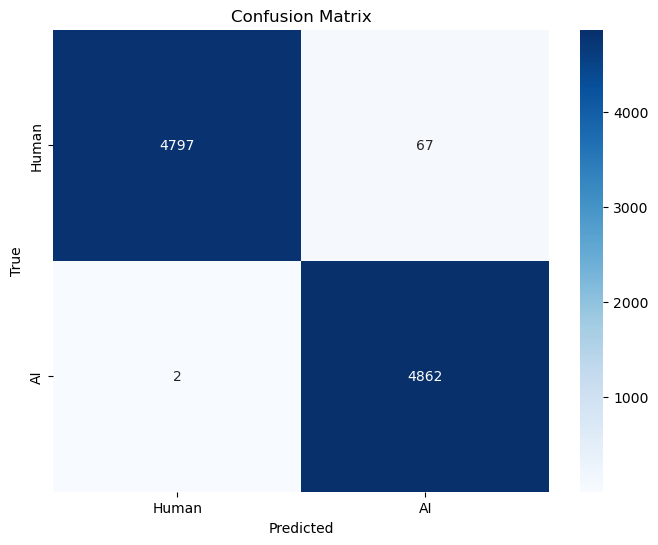

NameError: name 'epochs' is not defined

<Figure size 1000x600 with 0 Axes>

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for test set
y_true = df['label']
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        y_pred.extend(predicted.cpu().numpy())
class_names = ['Human', 'AI']  # Rename '0' to 'Human' and '1' to 'AI'
plot_confusion_matrix(y_true, y_pred, labels=class_names)
# plot_confusion_matrix(y_true, y_pred, labels=['0', '1'])  # Replace labels with actual class labels if different

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
